In [1]:
import napari
import numpy as np
import skimage
import pandas as pd
import timeit
import os
import ot
import matplotlib.pyplot as plot
from scipy.sparse import csr_matrix



# Define the directory where your image series is stored
path = '/Users/andrewrodriguez/Desktop/Files/OT_Testing/sample_data.csv'
df = pd.read_csv(path)

viewer = napari.Viewer()
napari.run()

In [2]:
if 'plate' in viewer.layers:
    viewer.layers.remove('plate')
plate_coords = [[-2, -2], [2, -2],[2, 2], [-2, 2]]
viewer.add_shapes(plate_coords, face_color = "white", opacity = 1, edge_color="white", edge_width=0)

<Shapes layer 'plate_coords' at 0x3221c54c0>

In [4]:

# Function to generate a random color
def get_color(val):
    if val == 0:
        c = "#FF0000"
    elif val == 1:
        c = "#0000FF"
    elif val == 2:
        c = "#FFA500"
    else:
        c = "#FFC0CB"
    return c

# Check if 'cells' layer exists and remove it
if 'cells' in viewer.layers:
    viewer.layers.remove('cells')

# Extract initial cell coordinates
init_cell_coords = df.loc[:, ['t_ind', 'y', 'x']].to_numpy()

# Extract ground truth values
ground_truth_values = df.loc[:, "ground_truth"].to_numpy()

# Get unique ground truth values and assign a unique color to each
unique_values = np.unique(ground_truth_values)
color_map = {val: get_color(val) for val in unique_values}

# Map the ground truth values to their corresponding colors
colors = [color_map[val] for val in ground_truth_values]

# Add points to the viewer with colors based on ground truth values
viewer.add_points(
    init_cell_coords,
    ndim=3,
    name='cells',
    face_color=colors,
    edge_color="black",
    edge_width=0.1,
    edge_width_is_relative=True,
    opacity=1,
    size=0.01,
    visible=True
)

<Points layer 'cells' at 0x35d011fd0>

In [6]:
# CONSTANTS

MAP_DIM = 400
WELL_DIM = 2
SIGMA_PIX = 1.5
SCALE = (WELL_DIM/MAP_DIM, WELL_DIM/MAP_DIM)
TRANSLATE =(-0.5 * WELL_DIM + (0.015/WELL_DIM), -0.5 * WELL_DIM + (0.015)/ WELL_DIM)



In [7]:
translated_df = df[["x", "y", "t_ind", "ground_truth", "in_scan"]].copy()
translated_df["x"] = (translated_df["x"] + WELL_DIM/2) * (MAP_DIM/WELL_DIM)
translated_df["y"] = (translated_df["y"] + WELL_DIM/2) * (MAP_DIM/WELL_DIM)
translated_df.head()

,x,y,t_ind,ground_truth,in_scan
0,200.624366,200.165816,0,0,False
1,203.136957,199.456584,0,0,False
2,199.547432,196.160172,0,0,False
3,205.156548,196.874591,0,0,False
4,198.570133,196.720617,0,0,False


In [8]:
time_set = []
times = translated_df["t_ind"].unique()

for time in translated_df["t_ind"].unique():
    this_time = translated_df[translated_df["t_ind"] == time]
    coords = this_time[['x', 'y']].values
    time_set.append(coords)

In [9]:
time_maps = []
growth_maps = []

for set in time_set:
    density_map = np.zeros((MAP_DIM, MAP_DIM))
    cell_coords = np.int64(set)
    current_cells = cell_coords
    n_cells = current_cells.shape[0]
    prop = np.ones(n_cells)  # just cell density

        
    # Populate the map with cell densities
    for idx in range(n_cells):
        density_map[cell_coords[idx, 1], cell_coords[idx, 0]] += prop[idx]*60000

    density_map = skimage.filters.gaussian(density_map, sigma=SIGMA_PIX, truncate=1) 
    # growth_map = density_map * (1/np.clip(
    #         3 * (  (1.4 * np.exp(0.8*((density_map/1000)-5))) / \
    #              (1 + np.exp(0.8*(density_map/1000)-5))) + \
    #                 ( (0.7) / (1+np.exp(3*((density_map/1000)-2))) ) , \
    #                     a_min = 0.75, a_max = 1))

    # print((density_map.max()))

    time_maps.append(density_map)
    # growth_maps.append(growth_map)


In [10]:
viewer.add_image(
   np.array(time_maps),
   colormap='gray',
   contrast_limits = None,
   opacity=1,
   name='Base',
   scale=SCALE,
   translate=TRANSLATE,
   visible=True
)

# viewer.add_image(
#    np.array(growth_maps),
#    colormap='I Purple',
#    contrast_limits = None,
#    opacity=0.5,
#    name='Growth',
#    scale=SCALE,
#    translate=TRANSLATE,
#    visible=True
# )

<Image layer 'Base' at 0x35d083890>

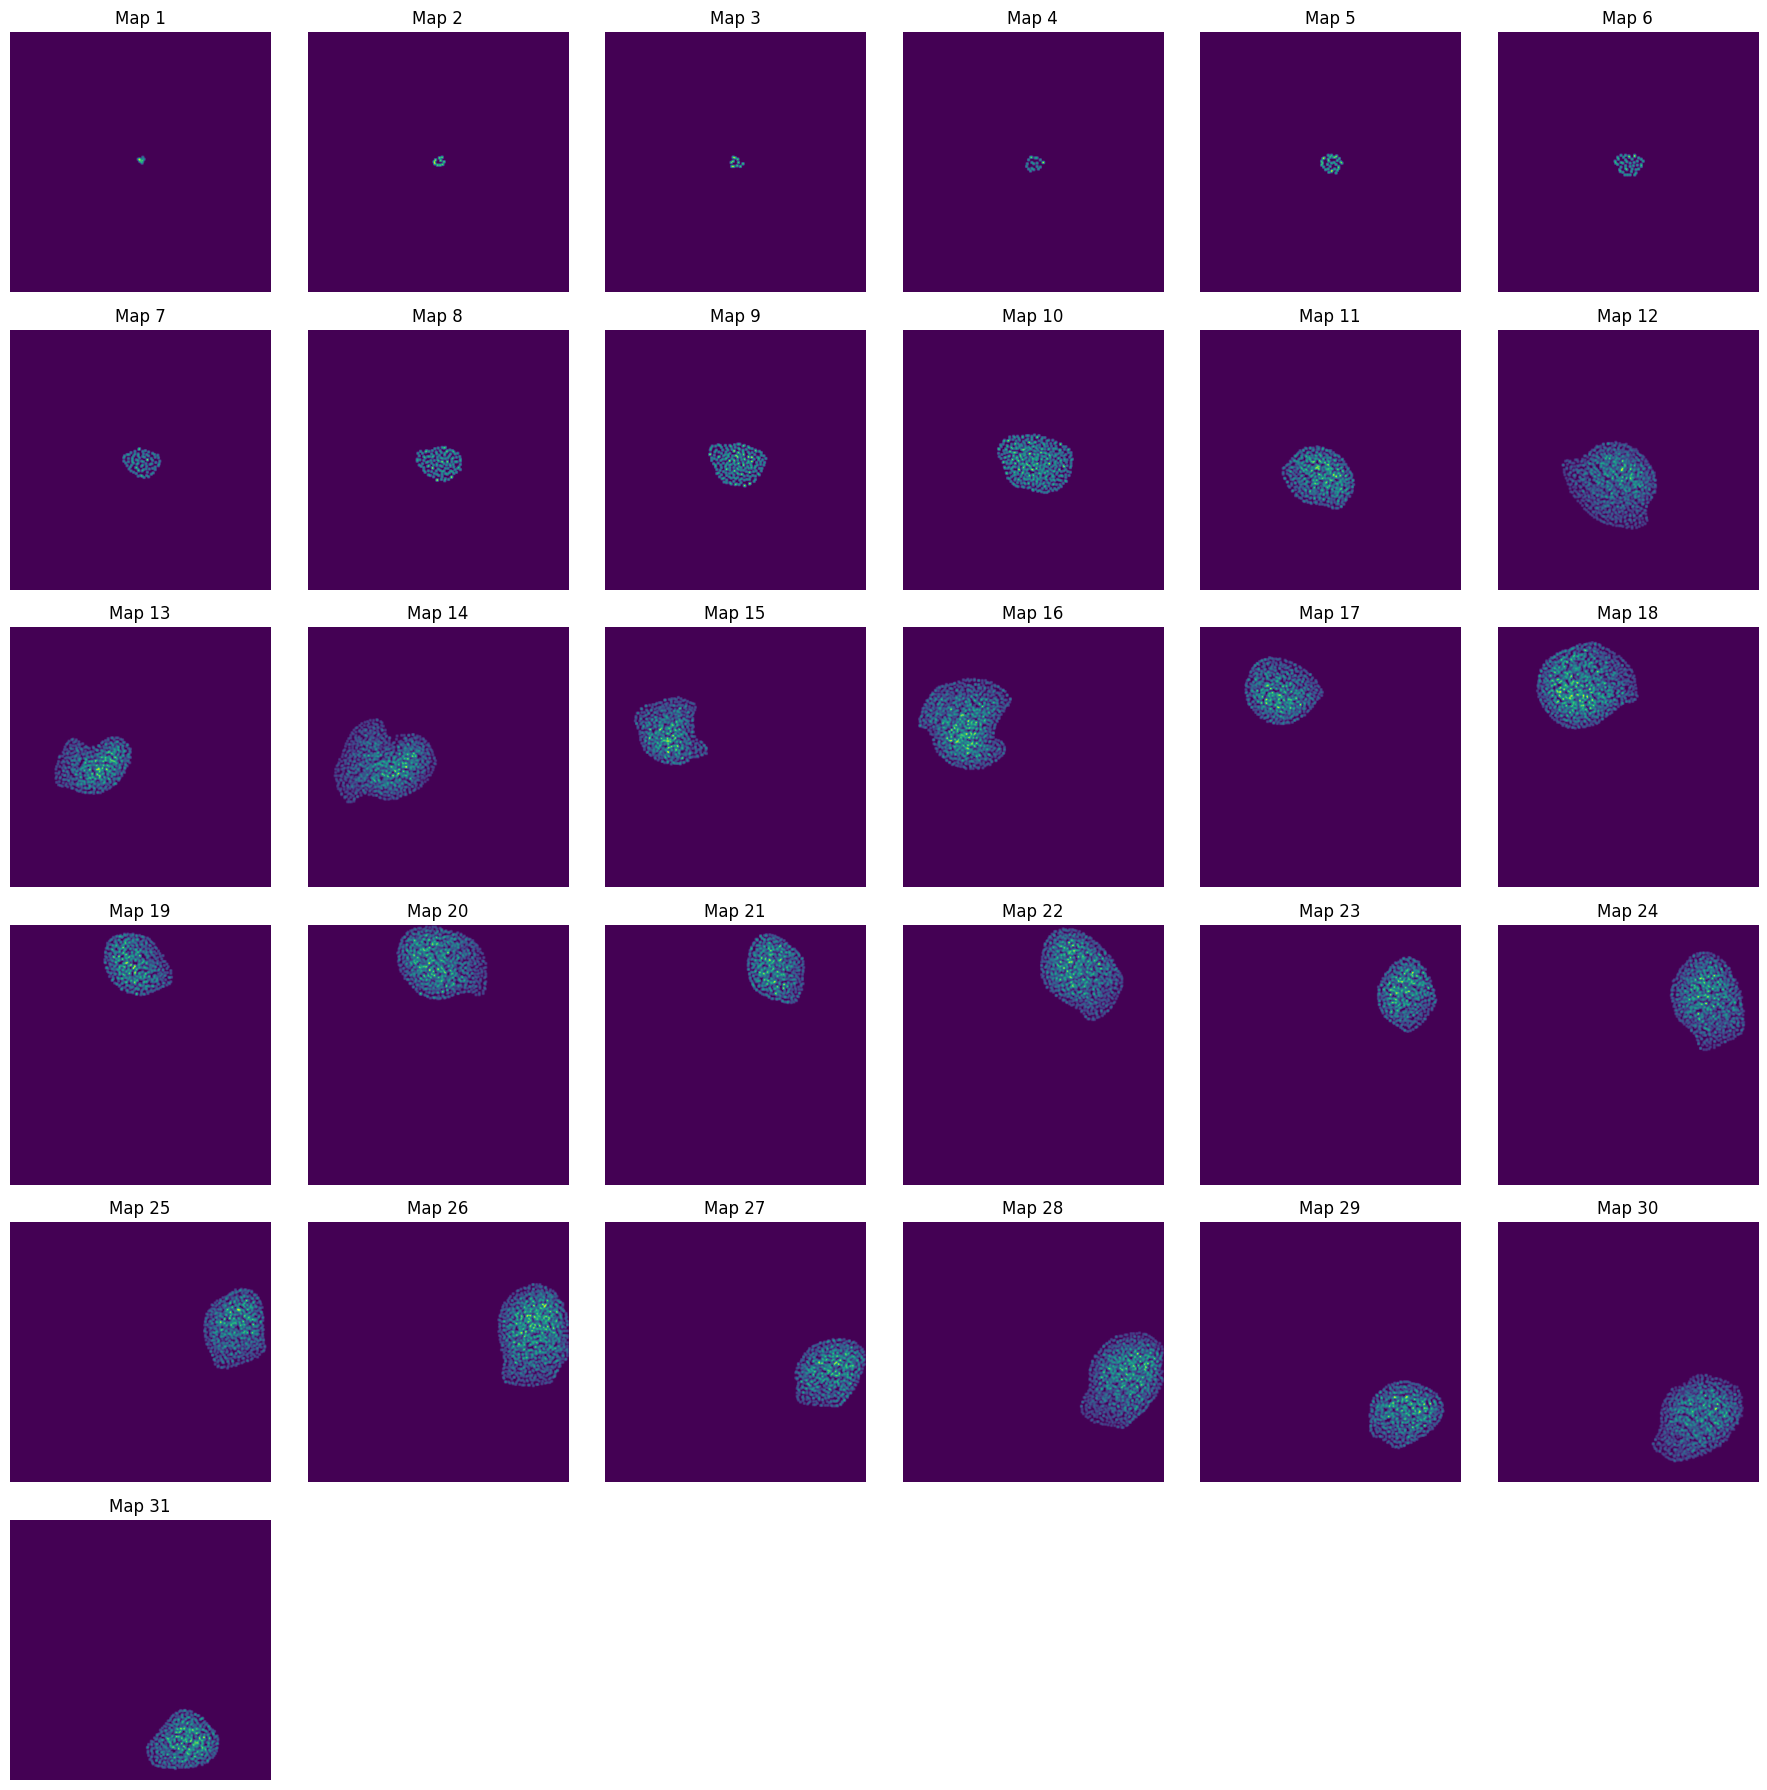

In [11]:
# Create a figure and a set of subplots with 6 rows and 6 columns
fig, axes = plot.subplots(6, 6, figsize=(18, 18))  # Adjust figsize as needed

for i, (ax, map) in enumerate(zip(axes.flatten(), time_maps)):
    ax.imshow(map)
    ax.set_title(f'Map {i+1}')  # Set label for each subplot
    ax.axis('off')  # Turn off axis if not needed

# If there are any remaining axes, turn them off
for j in range(i + 1, 36):
    fig.delaxes(axes.flatten()[j])

plot.tight_layout()
plot.show()

In [12]:
def pad_csr(csr_mat, rta, rtb, ctr, ctl):
    data = csr_mat.data
    indices = csr_mat.indices + ctl
    indptr = csr_mat.indptr

    rows_to_above = np.array([0] * rta)
    rows_to_below = np.array([indptr[-1]] * rtb)

    shifted_indptr = np.append(rows_to_above, indptr)
    shifted_indptr = np.append(shifted_indptr, rows_to_below)
    
    rows = csr_mat.shape[0]
    cols = csr_mat.shape[1]
    shifted =  csr_matrix((data, indices, shifted_indptr), shape=(rows+rta+rtb, cols+ctl+ctr))
    return(shifted)

In [13]:
def reshape_csr(csr_mat, frame_of_ref_indices, big_map_size):
     data = csr_mat.data
     indices = []
     for i in csr_mat.indices:
          indices.append(frame_of_ref_indices[i])
     indices = np.array(indices)

     indptr = [0]
     
     vals_in_row = []
     for i in range(1, len(csr_mat.indptr)):
          vals_in_row.append(csr_mat.indptr[i] - csr_mat.indptr[i - 1])

     row_counter = 0

     for i in range(big_map_size):
          if i in frame_of_ref_indices and i < big_map_size - 1:
               indptr.append(indptr[-1] + vals_in_row[row_counter])
               row_counter+=1
          else:
               indptr.append(indptr[-1])

     reshaped =  csr_matrix((data, indices, indptr), shape=(big_map_size, big_map_size))

     return reshaped

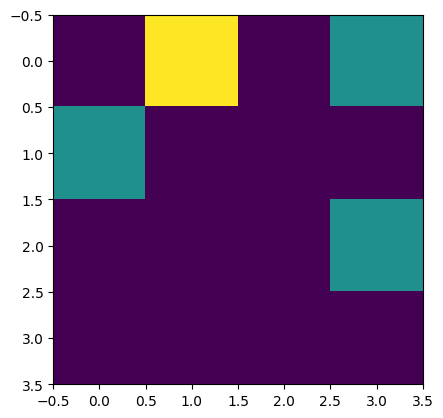

In [14]:
d = [2,1,1,1]
i = [1,3,0,3]
ip = [0,2,3,4,4]
shape = [4,4]
FOR = [4,5,7,8]
small = csr_matrix((d, i , ip), shape = shape)
plot.imshow(small.toarray())

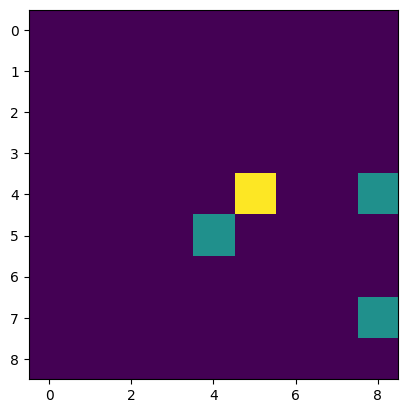

In [15]:
plot.imshow(reshape_csr(small, FOR, 9).toarray())

In [16]:
import concurrent.futures
import numpy as np
import pandas as pd
import skimage.filters
from scipy.sparse import csr_matrix
import ot


def process_time_step(i):

    print(f"Running Time Step {i}")

    ## Okay heres the work flow: build the large maps, downsize them to the smallest possible maps, extract the dimensions, build the cost matrix, run OT return the transport plan
    later_time = i + 1
    earlier_time = i

    later_df = translated_df[(translated_df["t_ind"] == later_time)]
    earlier_df = translated_df[(translated_df["t_ind"] == earlier_time) & (translated_df["in_scan"] == False)]

    later_coords = np.int64(later_df[['x', 'y']].values)
    earlier_coords = np.int64(earlier_df[['x', 'y']].values)

    later_n_cells = later_coords.shape[0]
    earlier_n_cells = earlier_coords.shape[0]

    later_map = np.zeros((MAP_DIM, MAP_DIM))
    earlier_map = np.zeros((MAP_DIM, MAP_DIM))

    later_prop = np.ones(later_n_cells)
    earlier_prop = np.ones(earlier_n_cells)

    for idx in range(later_n_cells):
        later_map[later_coords[idx, 1], later_coords[idx, 0]] += later_prop[idx]

    for idx in range(earlier_n_cells):
        earlier_map[earlier_coords[idx, 1], earlier_coords[idx, 0]] += earlier_prop[idx]

    later_map = skimage.filters.gaussian(later_map, sigma=SIGMA_PIX, truncate=1)
    earlier_map = skimage.filters.gaussian(earlier_map, sigma=SIGMA_PIX, truncate=1)



    # Okay that was all standard practice now lets do some downsampling


    x_pixels = []
    y_pixels = []

    # Find the bounds of non-zero values
    for xpx in range(len(later_map)):
        for ypx in range(len(later_map[xpx])):
            if later_map[xpx][ypx] > 0:
                x_pixels.append(xpx)
                y_pixels.append(ypx)

    for xpx in range(len(earlier_map)):
        for ypx in range(len(earlier_map[xpx])):
            if earlier_map[xpx][ypx] > 0:
                x_pixels.append(xpx)
                y_pixels.append(ypx)

    top_most_px = min(x_pixels)
    bottom_most_px = max(x_pixels)
    left_most_px = min(y_pixels)
    right_most_px = max(y_pixels)

    # Crop the map, adding +1 to the bottom_most_px and right_most_px to include the last pixel
    later_map_cropped = later_map[top_most_px:bottom_most_px+1, left_most_px:right_most_px+1]
    earlier_map_cropped = earlier_map[top_most_px:bottom_most_px+1, left_most_px:right_most_px+1]


    points = []
    ids = []
    c = 0

    for x in range(later_map_cropped.shape[0]):
        for y in range(later_map_cropped.shape[1]):
            points.append([x,y])
            ids.append(c)
            c+=1

    ids = np.array(ids)
    
    points = np.array(points)
    #print(f"Building Cost Matrix of Shape {later_map_cropped.shape[0]*later_map_cropped.shape[1]} by {later_map_cropped.shape[0]*later_map_cropped.shape[1]}")
    C = ot.dist(points, points)
    C = C.astype(np.int16)




    frame_of_reference = np.zeros((MAP_DIM, MAP_DIM))
    frame_of_reference[top_most_px:bottom_most_px+1, left_most_px:right_most_px+1] = 1
    
    frame_of_reference = frame_of_reference.flatten()

    indices_for_frame_of_reference = np.where(frame_of_reference == 1)[0]




    later_flat_map = later_map_cropped.flatten()
    
    earlier_flat_map = earlier_map_cropped.flatten()

    # earlier_flat_map =  eflat * (1/np.clip(
    #         3 * (  (1.4 * np.exp(0.8*((eflat/1000)-5))) / \
    #              (1 + np.exp(0.8*(eflat/1000)-5))) + \
    #                 ( (0.7) / (1+np.exp(3*((eflat/1000)-2))) ) , \
    #                     a_min = .75, a_max =2))

    scaling = sum(later_flat_map) / sum(earlier_flat_map) 

    earlier_flat_map *= scaling


    

    # instead of just multiplying by a constant we want to use our growth function

    emd = ot.emd(later_flat_map, earlier_flat_map, C, numItermax = 1E6)


    sparse_output = csr_matrix(emd)


    reshaped = reshape_csr(sparse_output, indices_for_frame_of_reference, MAP_DIM**2)




    # # Plot the cropped maps side by side
    # fig, axes = plot.subplots(1, 2, figsize=(10, 5))

    # axes[0].imshow(later_map_cropped, aspect='auto')
    # axes[0].set_title('Later Map')
    # axes[0].axis('off')  # Turn off axis

    # axes[1].imshow(earlier_map_cropped, aspect='auto')
    # axes[1].set_title('Earlier Map')
    # axes[1].axis('off')  # Turn off axis

    # plot.tight_layout()
    # plot.show()


    # fig, axes = plot.subplots(1, 2, figsize=(12, 6))

    # # Display the first image in the first subplot
    # axes[0].imshow(C)
    # axes[0].set_title('Cost Matrix')

    # # Display the second image in the second subplot
    # axes[1].imshow(ids.reshape(later_map_cropped.shape[0], later_map_cropped.shape[1]))
    # axes[1].set_title('IDs for Each Pixel')

    # # Remove axis for a cleaner look
    # for ax in axes:
    #     ax.axis('on')

    # plot.show()

    # plot.figure()

    # plot.imshow(frame_of_reference.reshape(MAP_DIM, MAP_DIM))

    # plot.show()
    


    return i, reshaped


sk = [None] * (len(times) - 1)
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    futures = {executor.submit(process_time_step, i): i for i in range(len(times) - 1)}
    for future in concurrent.futures.as_completed(futures):
        i, result = future.result()
        sk[i] = result

Running Time Step 0
Running Time Step 1
Running Time Step 2
Running Time Step 3
Running Time Step 4
Running Time Step 5
Running Time Step 6
Running Time Step 7
Running Time Step 8
Running Time Step 9
Running Time Step 10
Running Time Step 11
Running Time Step 12
Running Time Step 13
Running Time Step 14
Running Time Step 15
Running Time Step 16
Running Time Step 17
Running Time Step 18
Running Time Step 19
Running Time Step 20
Running Time Step 21
Running Time Step 22
Running Time Step 23
Running Time Step 24
Running Time Step 25
Running Time Step 26
Running Time Step 27
Running Time Step 28
Running Time Step 29


In [22]:

memory_usage = sk[0].toarray().nbytes

print(f"Memory usage of one transport matrix in dense form: {memory_usage/1E9} gigabytes")

Memory usage of one transport matrix in dense form: 204.8 gigabytes


In [23]:
csr = sk[-1]

# Check the memory usage of the CSR matrix
data_memory = csr.data.nbytes
indices_memory = csr.indices.nbytes
indptr_memory = csr.indptr.nbytes
total_memory = data_memory + indices_memory + indptr_memory

print(f"Memory usage of the data array: {data_memory} bytes")
print(f"Memory usage of the indices array: {indices_memory} bytes")
print(f"Memory usage of the indptr array: {indptr_memory} bytes")
print(f"Total memory usage of the CSR matrix: {total_memory/1E9} gigabytes")

Memory usage of the data array: 89568 bytes
Memory usage of the indices array: 44784 bytes
Memory usage of the indptr array: 640004 bytes
Total memory usage of the CSR matrix: 0.000774356 gigabytes


In [24]:

# def percentage_non_zero(matrix):
#     matrix = np.array(matrix)
#     total_elements = matrix.size
#     non_zero_elements = np.count_nonzero(matrix)
#     percentage = (non_zero_elements / total_elements) * 100
#     return percentage

# matrix = sk[-1].toarray()
# result = percentage_non_zero(matrix)
# print(f"Percentage of non-zero values: {result:.4f}%")

In [25]:
chains = []
gens_back = len(sk) - 1
parent_matrix = sk[len(sk) - 1]

for i in range(gens_back):
    start_time = timeit.default_timer()
    chains.append(parent_matrix.toarray())
    child_matrix = sk[len(sk) - (i + 2)]

    parent_matrix = parent_matrix.dot(child_matrix)


    end_time = timeit.default_timer()
    runtime = end_time - start_time
    print(f"Runtime for mat mul number {i}: {runtime:.4f} seconds")

chains.append(parent_matrix.toarray())

Runtime for mat mul number 0: 0.0084 seconds
Runtime for mat mul number 1: 0.0087 seconds
Runtime for mat mul number 2: 0.0087 seconds
Runtime for mat mul number 3: 0.0095 seconds
Runtime for mat mul number 4: 0.0095 seconds
Runtime for mat mul number 5: 0.0105 seconds
Runtime for mat mul number 6: 0.0102 seconds
Runtime for mat mul number 7: 0.0100 seconds
Runtime for mat mul number 8: 0.0093 seconds
Runtime for mat mul number 9: 0.0092 seconds
Runtime for mat mul number 10: 0.0101 seconds
Runtime for mat mul number 11: 0.0090 seconds
Runtime for mat mul number 12: 0.0099 seconds
Runtime for mat mul number 13: 0.0093 seconds
Runtime for mat mul number 14: 0.0099 seconds
Runtime for mat mul number 15: 0.0148 seconds
Runtime for mat mul number 16: 0.0086 seconds
Runtime for mat mul number 17: 0.0079 seconds
Runtime for mat mul number 18: 0.0095 seconds
Runtime for mat mul number 19: 0.0093 seconds
Runtime for mat mul number 20: 0.0089 seconds
Runtime for mat mul number 21: 0.0117 second

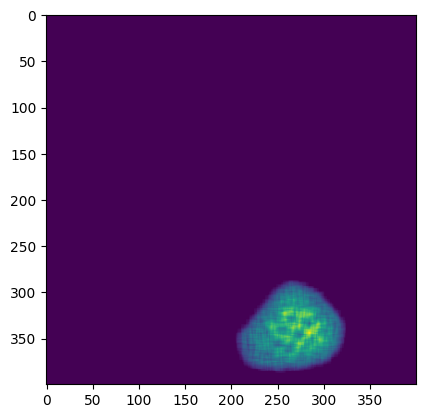

In [26]:
selected_cells = translated_df[(translated_df["ground_truth"] == 3) & (translated_df["t_ind"] == max(times))]
selected_coords = selected_cells[['x', 'y']].values

time_maps = []
selected_map = np.zeros((MAP_DIM, MAP_DIM))
cell_coords = np.int64(selected_coords)
current_cells = cell_coords
n_cells = current_cells.shape[0]
prop = np.ones(n_cells)  

for idx in range(n_cells):
    selected_map[cell_coords[idx, 1], cell_coords[idx, 0]] += prop[idx]

selected_map = skimage.filters.gaussian(selected_map, sigma=5, truncate=1)
plot.imshow(selected_map)

In [27]:
import random

flat_sel_map = selected_map.flatten()
selected_pix = []
valid_pixels = [i for i in range(len(flat_sel_map)) if flat_sel_map[i] > 0]
num_to_select = len(valid_pixels) // 10
selected_pix = random.sample(valid_pixels, num_to_select)

print(len(selected_pix))

890


In [28]:
import psutil

def check_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info().rss / (1024 ** 2)
    return memory_info


predicted_maps = []
cleaned_chains = []

for i in range(len(chains)):
    clean = []
    for pix in selected_pix:
        clean.append((chains[i][pix]))
    cleaned_chains.append(clean)
    sc = np.array(clean).sum(axis = 0).reshape(MAP_DIM, MAP_DIM)
    predicted_maps.append(sc)
    print(f"On iter {i} we are using {check_memory_usage()} MBS of RAM")



predicted_maps.reverse()
predicted_maps.append(selected_map)


On iter 0 we are using 6313.703125 MBS of RAM
On iter 1 we are using 6281.234375 MBS of RAM
On iter 2 we are using 6266.96875 MBS of RAM
On iter 3 we are using 6290.6875 MBS of RAM
On iter 4 we are using 6294.25 MBS of RAM
On iter 5 we are using 6366.578125 MBS of RAM
On iter 6 we are using 6301.84375 MBS of RAM
On iter 7 we are using 6244.234375 MBS of RAM
On iter 8 we are using 6279.765625 MBS of RAM
On iter 9 we are using 6338.40625 MBS of RAM
On iter 10 we are using 6433.0 MBS of RAM
On iter 11 we are using 6399.5625 MBS of RAM
On iter 12 we are using 6190.609375 MBS of RAM
On iter 13 we are using 6209.59375 MBS of RAM
On iter 14 we are using 6150.484375 MBS of RAM
On iter 15 we are using 6137.140625 MBS of RAM
On iter 16 we are using 6183.328125 MBS of RAM
On iter 17 we are using 6262.359375 MBS of RAM
On iter 18 we are using 6433.984375 MBS of RAM
On iter 19 we are using 6402.734375 MBS of RAM
On iter 20 we are using 6433.96875 MBS of RAM
On iter 21 we are using 6440.828125 MBS o

In [30]:
smoothed_predictions = []

for i in range(len(predicted_maps)):
    sig = np.clip(i-20, a_max=10, a_min = 2)
    predicted_map = skimage.filters.gaussian(predicted_maps[i], sigma=sig, truncate=1)
    smoothed_predictions.append(predicted_map)

In [31]:

predictions = smoothed_predictions


viewer.add_image(
   np.array(predictions),
   colormap='I Forest',
   contrast_limits = None,
   opacity=0.5,
   name='MtM',
   scale=SCALE,
   translate= TRANSLATE,
   visible=True
)


<Image layer 'MtM' at 0x36b4b26c0>

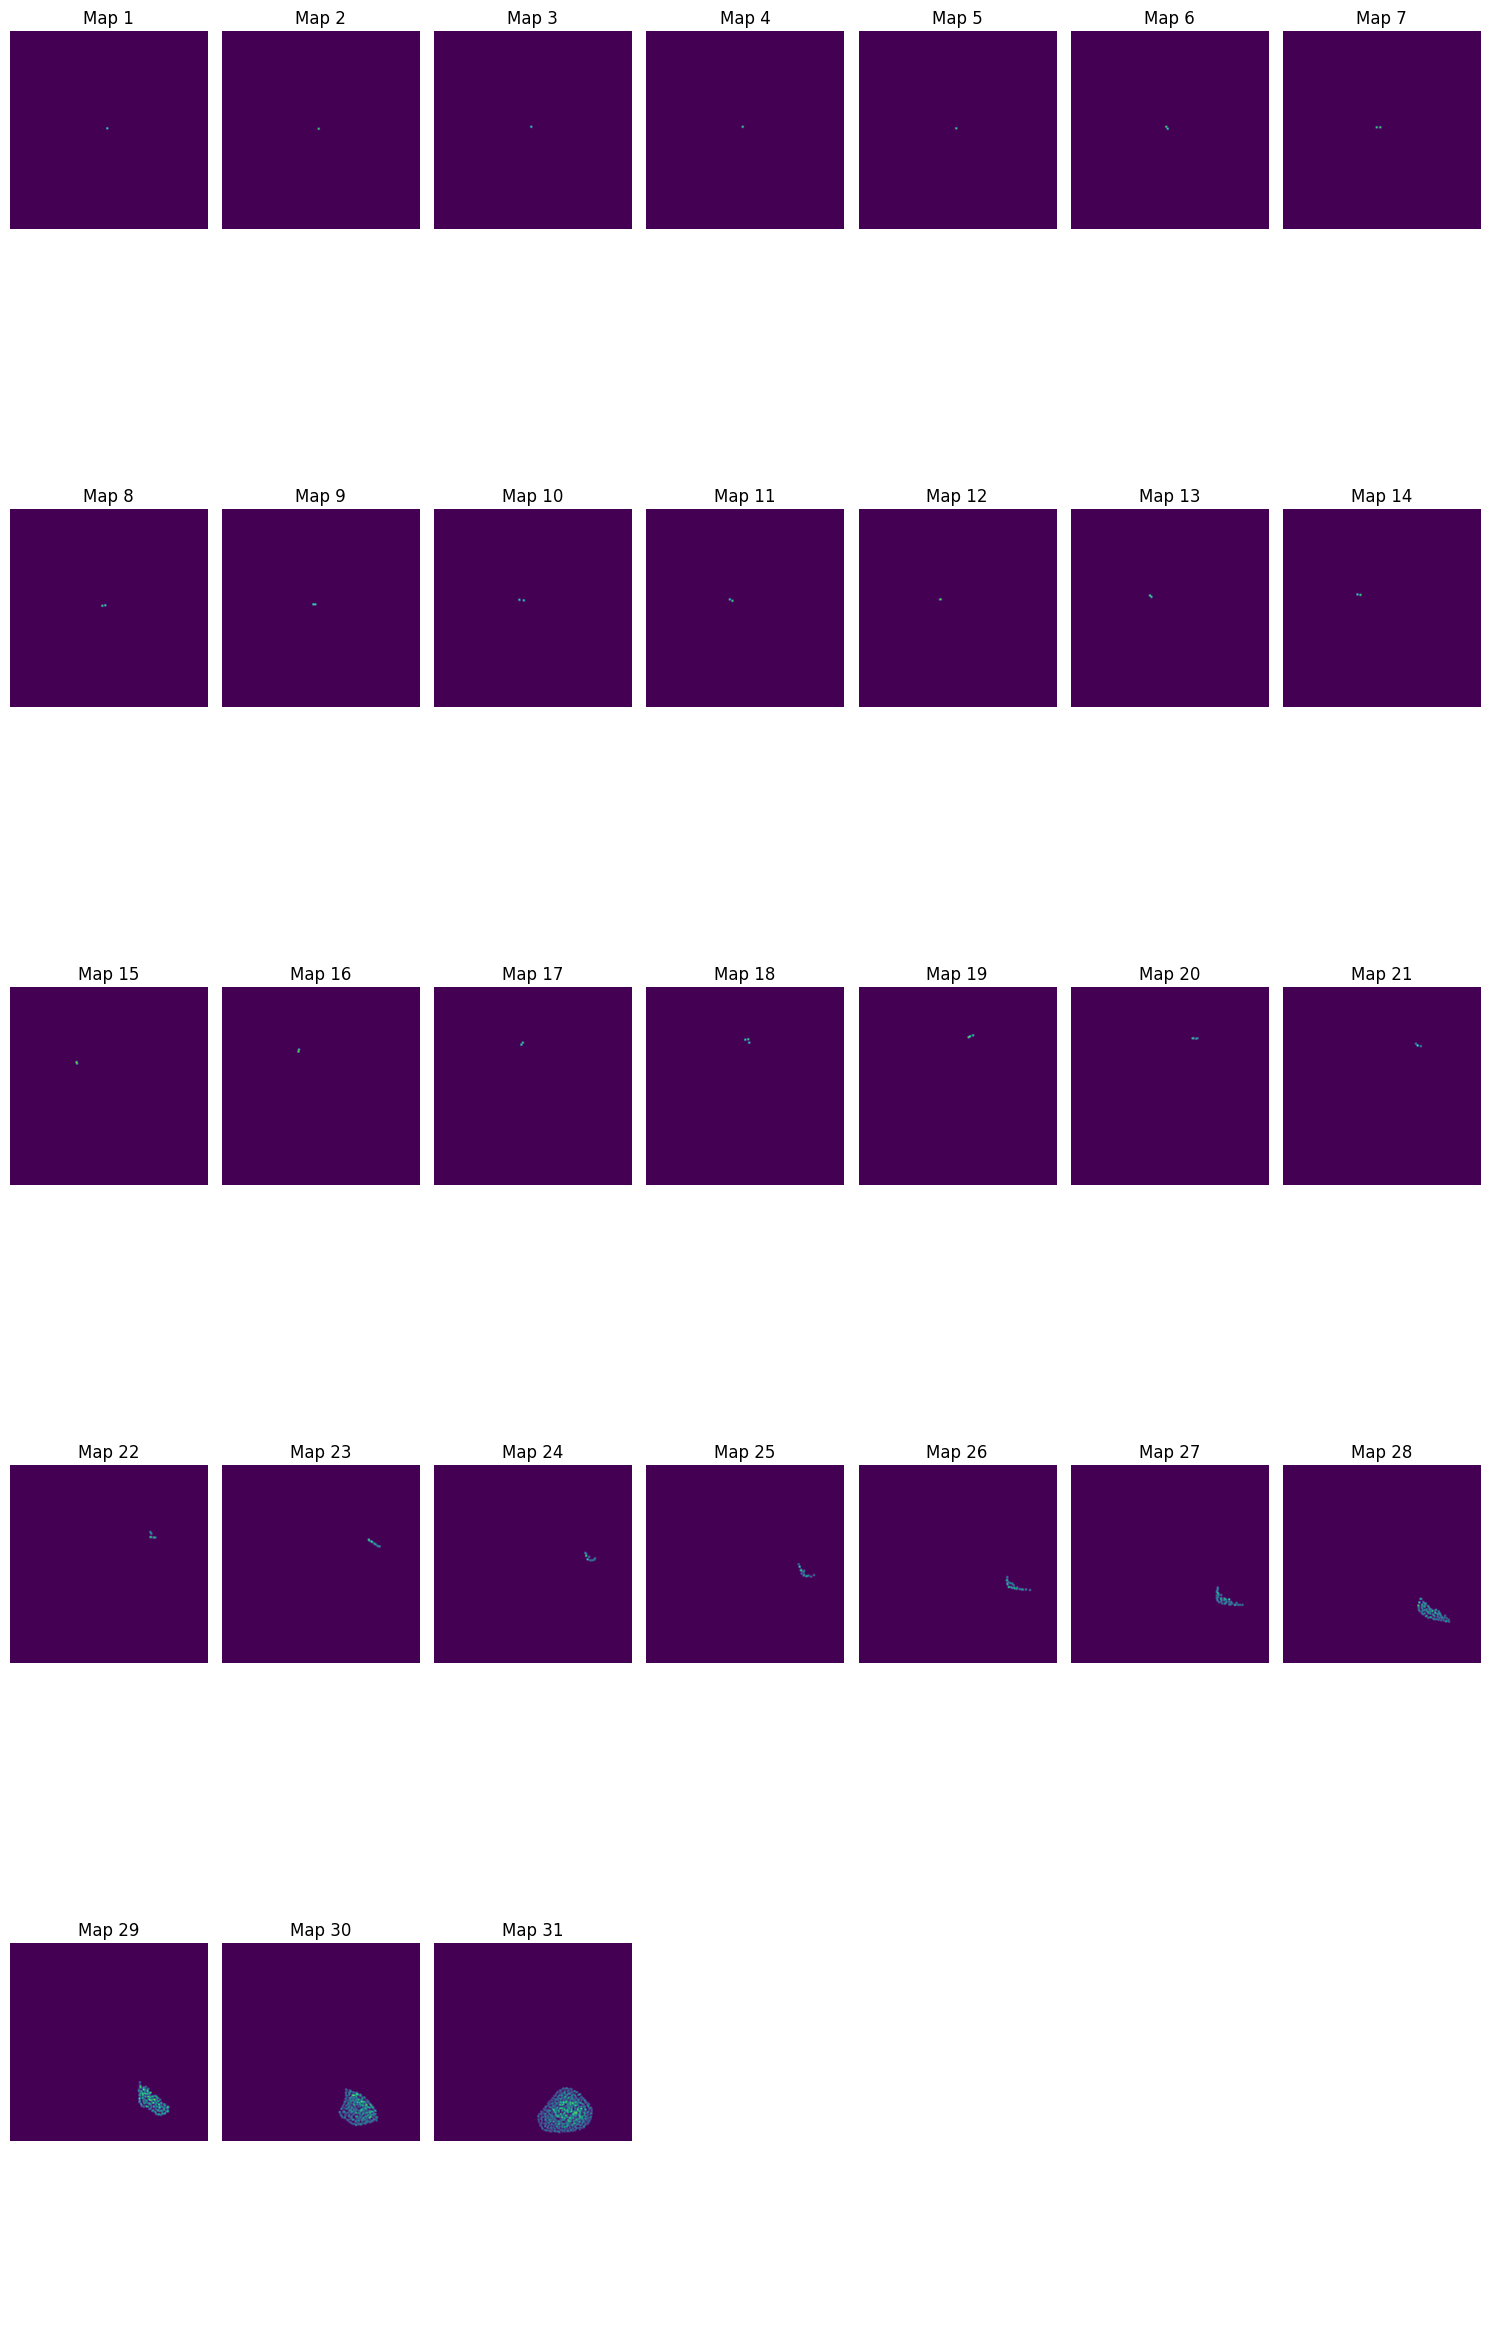

In [32]:
gt_set = []


for time in translated_df["t_ind"].unique():
   this_time = translated_df[(translated_df["t_ind"] == time) & (translated_df["ground_truth"] > 0)]
   coords = this_time[['x', 'y']].values
   gt_set.append(coords)


gt_maps = []


for set in gt_set:
   gt_map = np.zeros((MAP_DIM, MAP_DIM))
   cell_coords = np.int64(set)
   n_cells = cell_coords.shape[0]
   prop = np.ones(n_cells)  # just cell density


   # Populate the map with cell densities
   for idx in range(n_cells):
       gt_map[cell_coords[idx, 1], cell_coords[idx, 0]] += prop[idx]


   sigma_pix = 1
   gt_map = skimage.filters.gaussian(gt_map, sigma=SIGMA_PIX, truncate=1)


   gt_maps.append(gt_map)


num_maps = len(gt_maps)
rows = 5
cols = (num_maps + rows - 1) // rows  # Calculate number of columns needed


fig, axes = plot.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed


for i, map in enumerate(gt_maps):
   row = i // cols
   col = i % cols
   ax = axes[row, col]
   ax.imshow(map)
   ax.set_title(f'Map {i+1}')  # Set label for each subplot
   ax.axis('off')  # Turn off axis if not needed


# Turn off any remaining empty subplots
for j in range(i + 1, rows * cols):
   row = j // cols
   col = j % cols
   axes[row, col].axis('off')


plot.tight_layout()
plot.show()


In [33]:
viewer.add_image(
   np.array(gt_maps),
   colormap='I Purple',
   contrast_limits = None,
   opacity=0.5,
   name='GT',
   scale=SCALE,
   translate=TRANSLATE,
   visible=True
)

<Image layer 'GT' at 0x30b41b560>

In [25]:
import numpy as np

# Example gt_maps and predictions (replace these with your actual data)

# Ensure both lists have the same length
if len(gt_maps) != len(predictions):
    raise ValueError("The length of gt_maps and predictions must be the same.")

# Compute the difference between corresponding heat maps
differences = [pred - gt for gt, pred in zip(gt_maps, predictions)]


In [26]:
total_diffs = []


for i in range(len(differences)):
    total_diffs.append(sum(sum(differences[i]))**2/sum(sum(gt_maps[i]))**2)

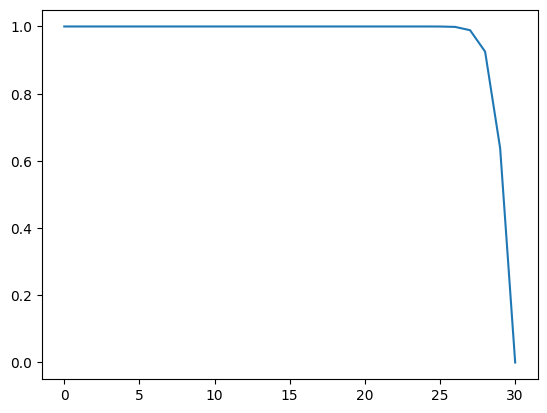

In [27]:
plot.plot(times, total_diffs)

In [32]:
import scipy
pearson_score = []
gens_back = []
for i in range(len(smoothed_predictions)):
    a = gt_maps[-1-i].flatten()
    b = smoothed_predictions[-1-i].flatten()
    gens_back.append(len(smoothed_predictions)-i)
    pearson_score.append(scipy.stats.pearsonr(a, b))

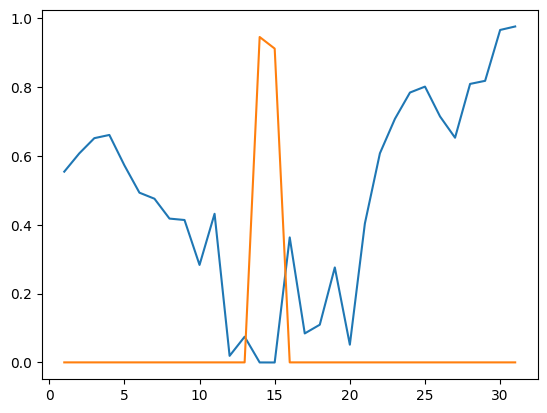

In [33]:
plot.plot(gens_back, pearson_score)